In [1]:
import numpy as np
import gym
from collections import deque
import random
import warnings

# Filter out DeprecationWarnings and UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


# https://github.com/openai/gym/blob/master/gym/core.py
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b



class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

**Networks:**
DDPG uses four neural networks:
1. a Q network
2. a deterministic policy network
3. a target Q network, and
4. a target policy network.

**Parameters:**
1. $\theta^Q$: $Q$ Network
2. $\theta^\mu$: Deterministic Policy Function
3. $\theta^{Q'}$: Target $Q$ Network
4. $\theta^{\mu'}$: Target Policy Function

The Q network and policy network is very much like simple Advantage Actor-Critic, but in DDPG, the Actor directly maps states to actions (the output of the network directly the output) instead of outputting the probability distribution across a discrete action space.

The target networks are time-delayed copies of their original networks that slowly track the learned networks. Using these target value networks greatly improve stability in learning.

Let's create these networks.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
from torch.autograd import Variable
import warnings

# Filter out DeprecationWarnings and UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

Now, let's create the DDPG agent. The agent class has two main functions: "get_action" and "update":



1. **get_action()**: This function runs a forward pass through the actor network to select a determinisitic action. In the DDPG paper, the authors use Ornstein-Uhlenbeck Process to add noise to the action output (Uhlenbeck & Ornstein, 1930), thereby resulting in exploration in the environment. Class OUNoise (in cell 1) implements this.

$$\mu'(s_t) = \mu(s_t \vert \theta_t^\mu) + \mathcal{N}$$

2. **update()**: This function is used for updating the actor and critic networks, and forms the core of the DDPG algorithm. The replay buffer is first sampled to get a batch of experiences of the form **<states, actions, rewards, next_states>**.

The value network is updated similarly as is done in Q-learning. The updated Q value is obtained by the Bellman equation. However, in DDPG, the next-state Q values are calculated with the target value network and target policy network. Then, we minimize the mean-squared loss between the updated Q value and the original Q value:

$$u_i = r_i + \gamma Q'(s_{i+1}, \mu'\left(s_{i+1}|\theta^{\mu'}\right))$$
$$Loss = \dfrac{1}{N}\sum\limits_{i}\left(y_i - Q(s_i, a_i \vert \theta^Q)\right)^2$$

For the policy function, our objective is to maximize the expected return. To calculate the policy loss, we take the derivative of the objective function with respect to the policy parameter. Keep in mind that the actor (policy) function is differentiable, so we have to apply the chain rule.

But since we are updating the policy in an off-policy way with batches of experience, we take the mean of the sum of gradients calculated from the mini-batch:

$$\nabla_{\theta^\mu}J(\theta) \approx \dfrac{1}{N}\sum\limits_{i}\left[\nabla_aQ(s,a\vert \theta^Q)\vert_{s=s_i, a=\mu(s_i)}\nabla_{\theta^\mu}\mu(s\vert \theta^\mu)\vert_{s=s_i}\right]$$

We make a copy of the target network parameters and have them slowly track those of the learned networks via “soft updates,” as illustrated below:

$$\theta^{Q'} \leftarrow \tau\theta^Q + (1 - \tau)\theta^{Q'}$$
$$\theta^{\mu'} \leftarrow \tau\theta^\mu + (1 - \tau)\theta^{\mu'}$$
where $\tau \ll 1$.

In [3]:
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
from torch.autograd import Variable
# from model import *
# from utils import *
import warnings

# Filter out DeprecationWarnings and UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
            target_param.requires_grad = False

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
            target_param.requires_grad = False

        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)

    def get_action(self, state):
        if isinstance(state, tuple):
            state = np.array(state[0])
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action

    def update(self, batch_size):
        states, actions, rewards, next_states, done = self.memory.sample(batch_size)
        states = [state[0] if isinstance(state, tuple) else state for state in states]
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        # Compute target values for critic loss
        with torch.no_grad():
            target_actions = self.actor_target(next_states)
            critic_value_ = self.critic_target(next_states, target_actions)
            target = rewards + self.gamma * critic_value_ * (1 - torch.FloatTensor(done))

        # Compute critic loss
        critic_value = self.critic(states, actions)
        critic_loss = self.critic_criterion(critic_value, target)

        # Update critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Compute actor loss
        new_policy_actions = self.actor(states)
        actor_loss = -self.critic(states, new_policy_actions).mean()

        # Update actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)

*Putting* it all together: DDPG in action.

The main function below runs 50 episodes of DDPG on the "Pendulum-v1" environment of OpenAI gym. This is the inverted pendulum swingup problem, a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright.

Each episode is for a maximum of 500 timesteps. At each step, the agent chooses an action, updates its parameters according to the DDPG algorithm and moves to the next state, repeating this process till the end of the episode.

The DDPG algorithm is as follows:

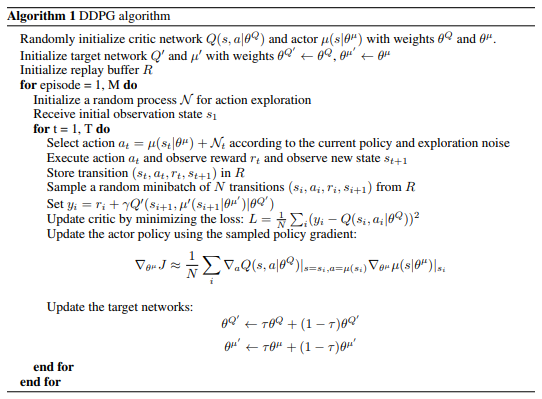

episode: 0, reward: -1433.55, average _reward: nan 
episode: 1, reward: -1378.62, average _reward: -1433.5491371472303 
episode: 2, reward: -1417.36, average _reward: -1406.0868190000772 
episode: 3, reward: -1446.79, average _reward: -1409.8455791568701 
episode: 4, reward: -818.98, average _reward: -1419.0826129587515 
episode: 5, reward: -1378.18, average _reward: -1299.0614254268453 
episode: 6, reward: -1115.06, average _reward: -1312.2485974883555 
episode: 7, reward: -928.81, average _reward: -1284.0787880980645 
episode: 8, reward: -1155.0, average _reward: -1239.669740183666 
episode: 9, reward: -648.09, average _reward: -1230.2624873828966 
episode: 10, reward: -620.99, average _reward: -1172.0455172146476 
episode: 11, reward: -518.4, average _reward: -1090.7899503651356 
episode: 12, reward: -612.73, average _reward: -1004.7676993022081 
episode: 13, reward: -257.79, average _reward: -924.3041074985997 
episode: 14, reward: -507.53, average _reward: -805.403807236323 
episo

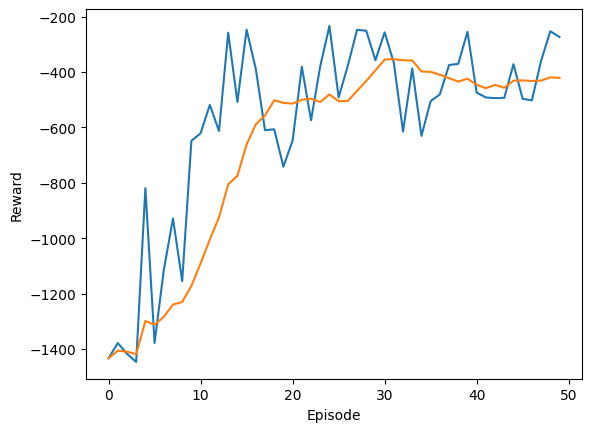

In [4]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Filter out DeprecationWarnings and UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

env = NormalizedEnv(gym.make("Pendulum-v1"))

agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 128
rewards = []
avg_rewards = []

for episode in range(50):
    state = env.reset()
    noise.reset()
    episode_reward = 0

    for step in range(500):
        action = agent.get_action(state)
        #Add noise to action

        action = noise.get_action(action)
        new_state, reward, done, info = env.step(action)
        agent.memory.push(state, action, reward, new_state, done)

        if len(agent.memory) > batch_size:
            agent.update(batch_size)

        state = new_state
        episode_reward += reward
        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

### Tutorial 7: An Overview
This code implements a Deep Deterministic Policy Gradient (DDPG) agent for solving the Pendulum-v1 environment from the OpenAI Gym. Below are some inferences about the code:

1. **Actor-Critic Architecture:**
- The agent implements an actor-critic architecture with separate neural networks for the actor and the critic. The actor network is responsible for learning the policy, while the critic network evaluates the actions taken by the actor.
- Both the actor and the critic networks consist of three fully connected layers with ReLU activations. The actor outputs actions after applying a hyperbolic tangent (tanh) activation to ensure actions are within the valid range.
2. **Ornstein-Uhlenbeck Noise:**
- The OUNoise class implements Ornstein-Uhlenbeck noise, which is used for exploration in continuous action spaces. This noise process adds temporally correlated noise to the actions, helping exploration while ensuring smoothness.
3. **Memory Replay Buffer:**
- The Memory class implements a replay buffer to store experiences (state, action, reward, next state, done) for experience replay. This allows the agent to sample mini-batches of experiences randomly for training, which stabilizes and accelerates learning.
4. **Normalization of Actions:**
- The NormalizedEnv class wraps the action space of the environment. It scales and shifts the actions to ensure they fall within a specific range, typically [-1, 1]. This helps stabilize learning in cases where the action space has varying bounds.
5. **Training Loop:**
- The training loop iterates over a fixed number of episodes. Within each episode, the agent interacts with the environment for a fixed number of steps (500 steps in this case).
- After each step, the agent stores the experience in its replay buffer and updates its networks if the buffer contains enough experiences.
- The loop tracks the cumulative reward obtained in each episode and computes the average reward over the last 10 episodes.
6. **Plotting and Output:**
- After training, the code plots the rewards obtained in each episode as well as the average rewards over the last 10 episodes. This provides insight into the agent's learning progress.
- The output shows the episode number, the total reward obtained in that episode, and the average reward over the last 10 episodes.
7. **Observations:**
- The training process seems to be making progress, as evidenced by the decreasing trend in rewards over the episodes.
- However, there might be room for improvement, as the rewards are still negative, indicating suboptimal performance. Further tuning of hyperparameters or network architectures may be necessary to achieve better results.


Overall, the code effectively implements a DDPG agent for solving the Pendulum-v1 environment, utilizing actor-critic architecture, Ornstein-Uhlenbeck noise, and experience replay for efficient learning in continuous action spaces.






### Network Sizes and Hyperparameters
Here's an overview of the network sizes and hyperparameters used in the provided code:

#### Network Sizes:
1. **Actor Network:**

- Input Size: Determined by the number of state variables in the environment.
- Hidden Layer Size: 256 neurons for each of the two hidden layers.
- Output Size: Determined by the number of action variables in the environment.
2. **Critic Network:**

- Input Size: Sum of the number of state variables and action variables in the environment.
- Hidden Layer Size: 256 neurons for each of the two hidden layers.
- Output Size: Single output representing the estimated Q-value.

#### Hyperparameters:
1. **Actor Learning Rate:** $10^{-4}$
2. **Critic Learning Rate:** $10^{-3}$
3. **Discount Factor ($\gamma$):** 0.99 \\
Gamma determines the importance of future rewards compared to immediate rewards. A value close to 1 indicates a high emphasis on future rewards.
4. **Soft Update Parameter ($\tau$):** $10^{-2}$ \\
$\tau$ determines the rate at which the target networks are updated towards the primary networks. A small value ensures a slow and smooth update of target networks.
5. **Maximum Memory Size:** 50000 \\
This determines the maximum size of the replay buffer, which stores past experiences for training the agent through experience replay.
6. **Ornstein-Uhlenbeck Process Parameters:**
 - **Mean or Average ($\mu$):** 0.0
 - **Reversion rate ($\theta$):** 0.15
 - **Maximum volatility in the noise amplitude ($\sigma_{max}$):** 0.3
 - **Minimun volatility in the noise amplitude ($\sigma_{min}$):** 0.3
 - **Duration of noise reduction (Decay Period):** 100000 \\
These parameters control the behavior of the Ornstein-Uhlenbeck noise process used for exploration.
7. **Other Details:**
- The **Adam optimizer** is used for both the actor and critic networks with the specified learning rates.
- The **Mean Squared Error (MSE)** loss function is used for the critic network.
- The **ReLU** activation function is used for hidden layers in both actor and critic networks, with a **hyperbolic tangent (tanh)** activation function for the actor's output layer.

These network sizes and hyperparameters are common choices for DDPG agents and can provide a good starting point for solving continuous control tasks like the Pendulum-v1 environment. However, tuning these parameters based on specific task requirements and experimental observations may be necessary for optimal performance.

### Inference
Looking at the plots of reward vs. episode and average reward vs. episode provides valuable insights into the learning progress of the DDPG agent. Here are some inferences we can draw from these plots:

1. **Reward Progression:**
- The reward plot shows an upward trend over episodes, indicating that the agent is learning to achieve higher rewards over time. This suggests that the agent is making progress in learning to solve the task.
- Initially, the rewards is highly negative, indicating poor performance. However, as training progresses, the rewards tend to stabilize and improve, approaching a saturated negative value.
2. **Variance in Reward:**

- There might be considerable variance in the rewards obtained across episodes, as seen from the fluctuations in the reward plot. This variability is expected during the learning process, especially in the early stages when the agent's policy is still evolving.
- Variability in rewards could arise due to stochasticity in the environment, exploration-exploitation trade-offs, or the randomness introduced by the Ornstein-Uhlenbeck noise during exploration.
3. **Convergence:**

- The convergence of the reward plot towards zero or positive values indicates that the agent is converging towards a better policy. This convergence suggests that the agent is gradually learning to achieve higher rewards and is getting closer to solving the task optimally.
- However, it's essential to monitor the stability of this convergence. Sudden spikes or drops in reward might indicate issues such as instability in training or suboptimal learning rates.
4. **Average Reward Trend:**

- The plot of average reward versus episode provides a smoothed view of the agent's learning progress. The increasing trend in average reward indicates consistent improvement in the agent's performance over time.
- This upward trend suggests that the agent's learning process is effective, as it is gradually learning to achieve higher rewards on average. The smoothness of the curve indicates that the learning process is stable and that the agent is making steady progress without significant fluctuations.
5. **Maxima in Average Reward:**

- Around episode 30, there is a peak in the average reward with its value being -393.6781597874789 , indicating that the agent achieved its best performance up to that point during training.
- This peak suggests that the agent's learning process was successful in discovering a policy that yielded relatively high rewards compared to earlier episodes.
6. **Subsequent Oscillation:**
- Following the peak in average reward, there is a decrease in the average reward in subsequent episodes followed by an increase.
- The oscillation in average reward suggests that the agent's performance has been saturated and the learned policy became became effective in generating rewards with its mean about -400.
- But, there is still a high variance in the actual reward suggesting stochasticity in the learning.

Overall, the plots of reward versus episode and average reward versus episode serve as essential diagnostic tools for monitoring the training progress of the DDPG agent in solving the Pendulum-v1 environment. They provide insights into the agent's learning trajectory, convergence behavior, and overall performance trends, with the increasing and smooth trend in average rewards indicating effective learning and progress towards solving the task.